# Time Series with XGBoost - Kaggle Tutorial
https://www.kaggle.com/furiousx7/xgboost-time-series/

## Import Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
#from statsmodels.graphics.tsaplots import plot_acf

## Import Data

In [2]:
energy_hourly = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [3]:
#Indices are not sorted - order the readings
energy_hourly.sort_index(inplace=True)

In [4]:
#PJME_MW - MW per hour in PJM East Area
energy_hourly.head(3)

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0


## Split the data

In [5]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [6]:
train, test = split_data(energy_hourly, '01-Jan-2015')

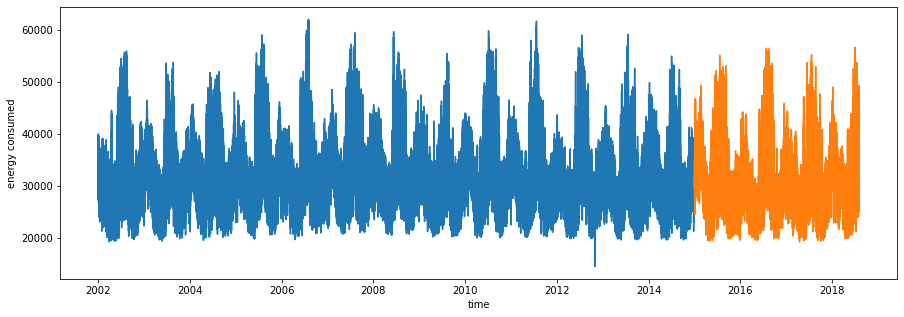

In [7]:
# Plot the train & test data
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

## Feature Engineering

In [8]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [9]:
X_train, y_train = create_features(train), train['PJME_MW']
X_test, y_test   = create_features(test), test['PJME_MW']

X_train.shape, y_train.shape

/home/moby/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


((113927, 8), (113927,))

In [10]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-01-01 01:00:00,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,5,1,1,1,2002,1,1,1


## Train the Model

In [11]:
reg = xgb.XGBRegressor(
    n_estimators=1000
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=10)

[0]	validation_0-rmse:23192.05859	validation_1-rmse:22274.66992
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2983.51636	validation_1-rmse:3736.42993
[20]	validation_0-rmse:2519.88379	validation_1-rmse:3902.70898
[30]	validation_0-rmse:2295.52563	validation_1-rmse:3983.68408
[40]	validation_0-rmse:2200.49268	validation_1-rmse:4043.85449
[50]	validation_0-rmse:2089.57910	validation_1-rmse:4096.81934
[60]	validation_0-rmse:1977.89502	validation_1-rmse:4152.70898
Stopping. Best iteration:
[10]	validation_0-rmse:2983.51636	validation_1-rmse:3736.42993



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Performance Metrics

In [17]:
# Mean Squared Error
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

13960913.30565261

In [18]:
# Mean Absolute Error
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)


2757.2169004982866

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

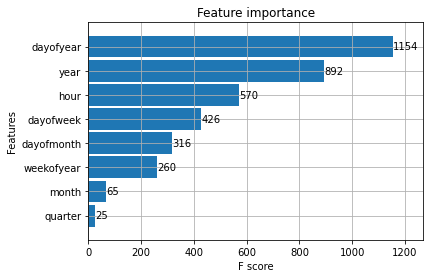

In [22]:
xgb.plot_importance(reg, height=0.9)

## Forecast on Test Data

In [13]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(energy_hourly.index,energy_hourly, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

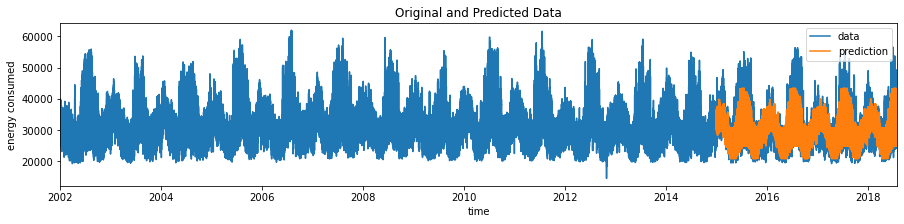

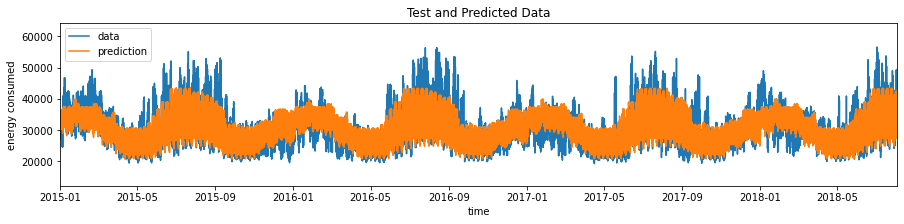

In [15]:
X_test_pred = reg.predict(X_test)
    
plot_performance(
    energy_hourly, 
    energy_hourly.index[0].date(), 
    energy_hourly.index[-1].date(),
    'Original and Predicted Data'
)

plot_performance(
    y_test, y_test.index[0].date(), 
    y_test.index[-1].date(),
    'Test and Predicted Data')

#plot_performance(
#    y_test, '01-01-2015', 
#    '02-01-2015', 
#    'January 2015 Snapshot')

plt.legend()
plt.show()

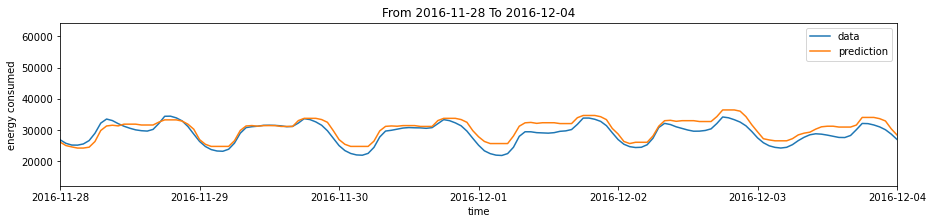

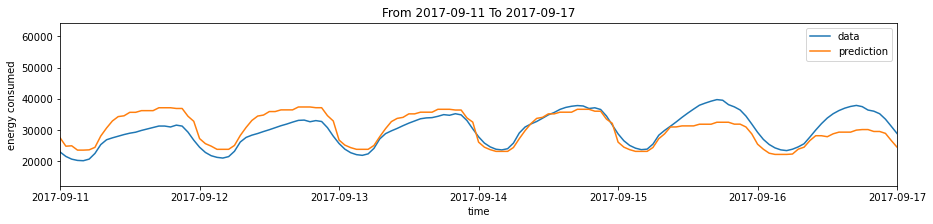

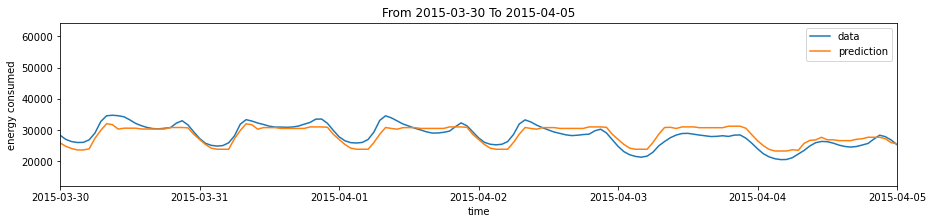

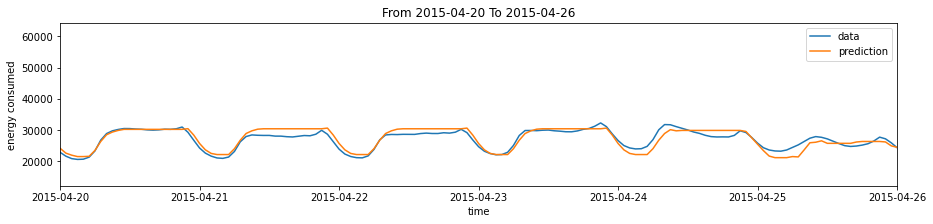

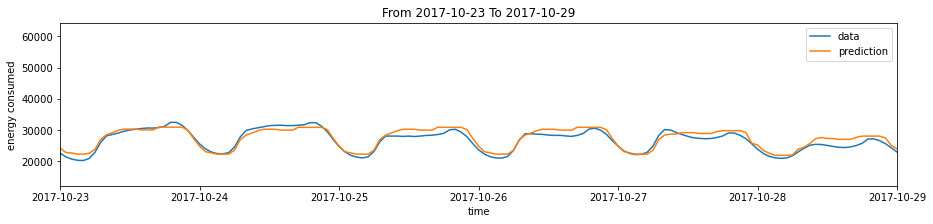

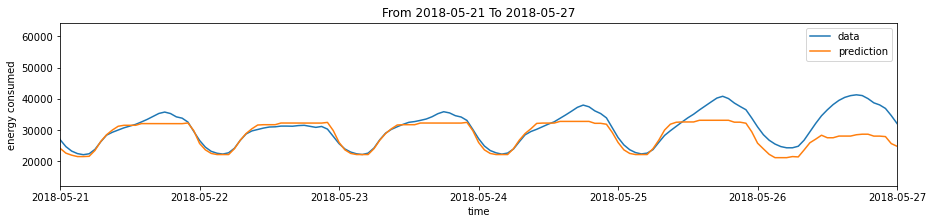

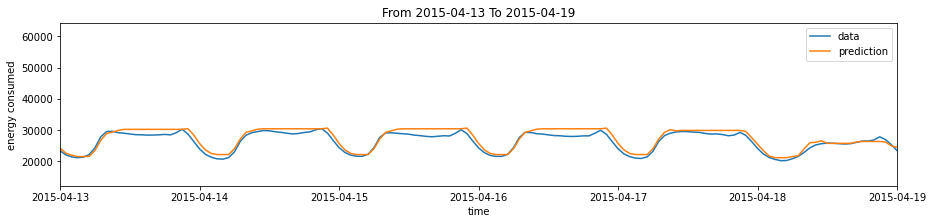

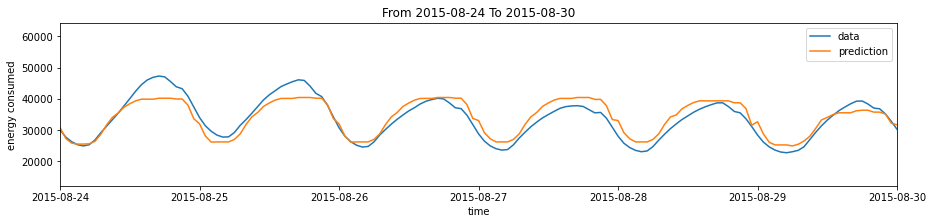

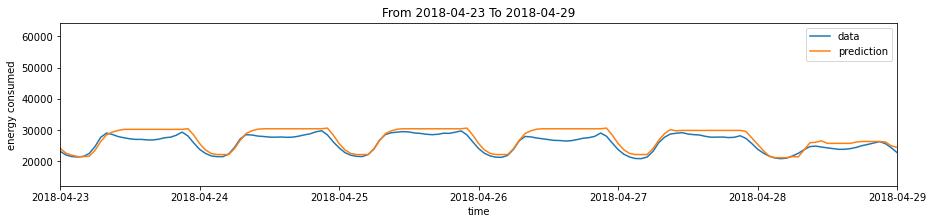

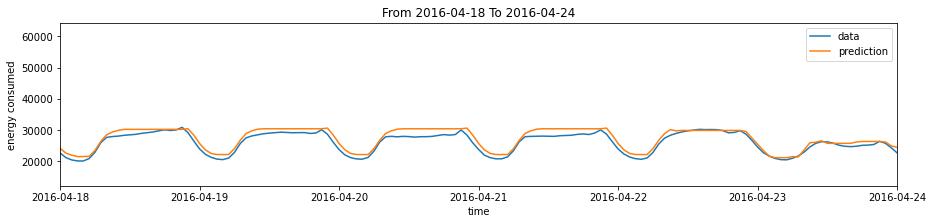

In [16]:
random_weeks = X_test[['year', 'weekofyear']].sample(10)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.weekofyear == week[1].weekofyear)
    data = y_test[index]
    plot_performance(data, data.index[0].date(), data.index[-1].date())